<a href="https://colab.research.google.com/github/AlphaK1/Customer-Segmentation/blob/main/customer_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
SEED = 123
import os
import random as rn
import numpy as np
import tensorflow as tf

os.environ['PYTHONHASHSEED']=str(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)
rn.seed(SEED)

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


from sklearn.preprocessing import StandardScaler, normalize
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA


import tensorflow.keras.backend as K
from tensorflow.python.keras import Sequential
from tensorflow.keras import layers, optimizers
from tensorflow.keras.layers import *
from tensorflow.keras import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint, LearningRateScheduler

import warnings
warnings.filterwarnings("ignore")

# Load The Data

In [2]:
#Load the data
df = pd.read_excel('data.xlsx')

In [3]:
#Check quality of the columns
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   Merchant_Id             200 non-null    int64 
 1   Annual_Revenue_(k$)     200 non-null    int64 
 2   Spending Score_(1-100)  200 non-null    int64 
 3   City                    200 non-null    object
 4   Most_Purchased_Product  200 non-null    object
dtypes: int64(3), object(2)
memory usage: 7.9+ KB


# Exploratory Data Analysis

In [4]:
#Check unique elements in each column
df.nunique()

Merchant_Id               200
Annual_Revenue_(k$)        64
Spending Score_(1-100)     84
City                        4
Most_Purchased_Product      4
dtype: int64

In [5]:
df.columns = df.columns.str.lower()

In [6]:
#Drop merchant_id
df.drop('merchant_id', 1, inplace=True)

In [7]:
df.columns

Index(['annual_revenue_(k$)', 'spending score_(1-100)', 'city',
       'most_purchased_product'],
      dtype='object')

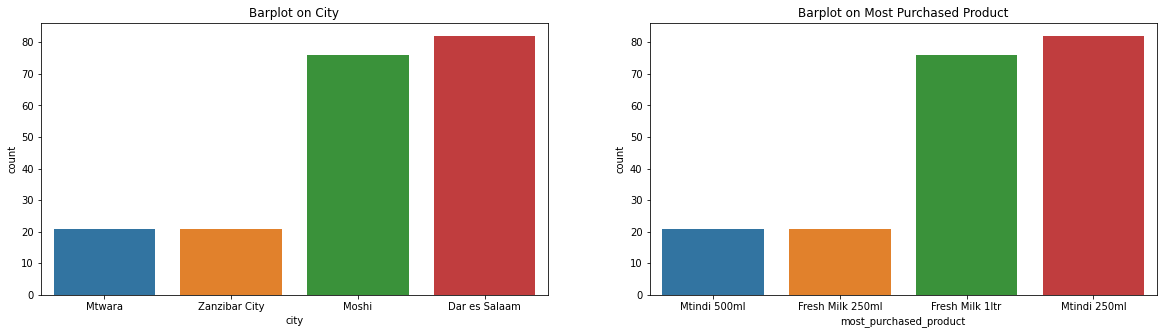

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.countplot(x = "city", data = df, ax=ax[0])
ax[0].set_title("Barplot on City")
sns.countplot(x = "most_purchased_product", data = df, ax=ax[1])
ax[1].set_title("Barplot on Most Purchased Product")
plt.show()

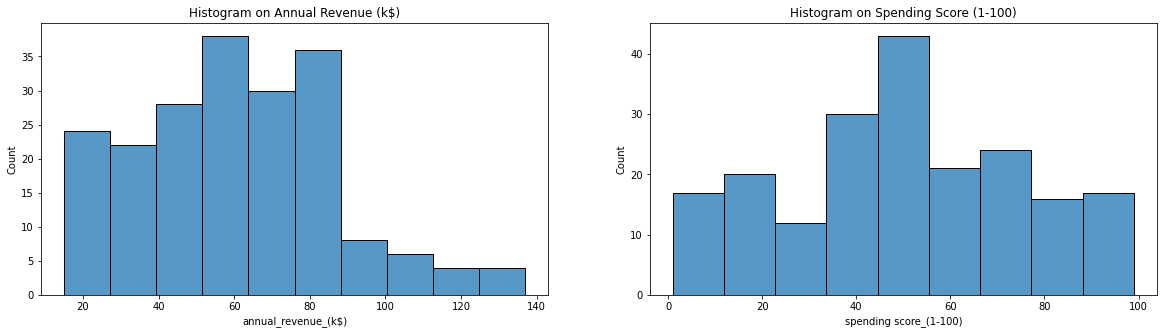

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.histplot(x = "annual_revenue_(k$)", data = df, ax=ax[0])
ax[0].set_title("Histogram on Annual Revenue (k$)")
sns.histplot(x = "spending score_(1-100)", data = df, ax=ax[1])
ax[1].set_title("Histogram on Spending Score (1-100)")
plt.show()

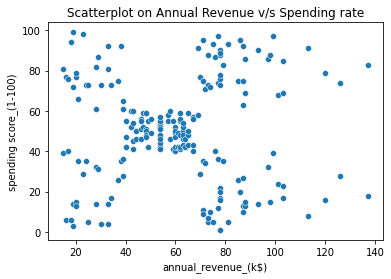

In [10]:
# Annual Revenue v/s Spending rate
sns.scatterplot(x = "annual_revenue_(k$)", y="spending score_(1-100)", data = df)
plt.title("Scatterplot on Annual Revenue v/s Spending rate")
plt.show()

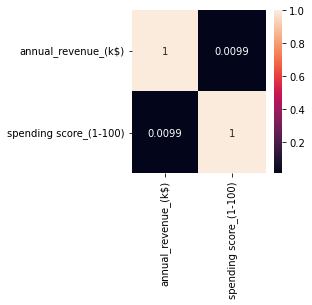

In [11]:
#Correlation matrix on numerical data
plt.figure(figsize = (3, 3))
corr_matrix = df.iloc[:, :2].corr()
sns.heatmap(corr_matrix, annot=True);

In [12]:
df.columns

Index(['annual_revenue_(k$)', 'spending score_(1-100)', 'city',
       'most_purchased_product'],
      dtype='object')

In [13]:
df[['city', 'most_purchased_product']].value_counts(normalize=True)

city           most_purchased_product
Dar es Salaam  Mtindi 250ml              0.410
Moshi          Fresh Milk 1ltr           0.380
Mtwara         Mtindi 500ml              0.105
Zanzibar City  Fresh Milk 250ml          0.105
dtype: float64

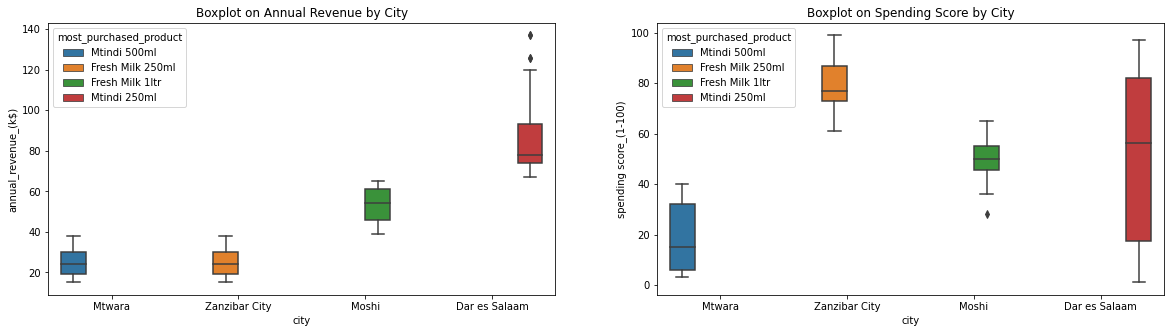

In [14]:
fig, ax = plt.subplots(1, 2, figsize=(20,5))
sns.boxplot(x="city", y="annual_revenue_(k$)", data=df, hue='most_purchased_product', ax=ax[0])
ax[0].set_title("Boxplot on Annual Revenue by City")
sns.boxplot(x="city", y="spending score_(1-100)", data=df, hue='most_purchased_product', ax=ax[1])
ax[1].set_title("Boxplot on Spending Score by City")
plt.show()

## Discoveries from EDA


1. Most of the merchants are from Dar es Salaam followed by Moshi at 41% and 38% respectively.
2. Mtwara and Zanzibar have the same number of merchants at 10.5% each.
3. Most purchased product is unique for each city.
4. There is no correlation between annual revenue and spending score.
5. The annual revenue for Dar es Salaam is highest averaging at 85 (k\$) followed by Moshi averaging at 53 (k\$).
6. Mtwara and Zanzibar have the least annual revenue averaging at 25 (k\$).
7. Zanzibar has the highest spending score averaging at 80, followed by Dar es Salaam at 51, which is closely followed by Moshi at 50 and Mtwara has the least spending score at 20.





# Data Preparation & Modelling using Clustering Algorithm

In [15]:
#Remove most purchaced product since it's unique for each city 
#i.e Mtindi 500ml for Mtwara, Fresh Milk 250ml for Zanzibar, Fresh Milk 1 ltr for Moshi and Mtindi 250ml for Dar es Salaam
df_new = df.drop('most_purchased_product', 1)

In [16]:
#Encoding catgorical variables
df_en = pd.get_dummies(data=df_new, columns=['city'])

In [17]:
df_en.head()

,annual_revenue_(k$),spending score_(1-100),city_Dar es Salaam,city_Moshi,city_Mtwara,city_Zanzibar City
0,15,39,0,0,1,0
1,15,81,0,0,0,1
2,16,6,0,0,1,0
3,16,77,0,0,0,1
4,17,40,0,0,1,0


In [18]:
df_en.shape, df_en.columns

((200, 6),
 Index(['annual_revenue_(k$)', 'spending score_(1-100)', 'city_Dar es Salaam',
        'city_Moshi', 'city_Mtwara', 'city_Zanzibar City'],
       dtype='object'))

In [19]:
# Scale the data
scaler = StandardScaler()
df_scaled = scaler.fit_transform(df_en)

## KMeans Clustering

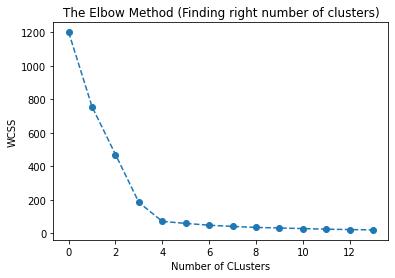

In [20]:
#Get optimal clusters for KMeans Clustering
wcss = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(df_scaled)
    wcss.append(kmeans.inertia_) # intertia is the Sum of squared distances of samples to their closest cluster center (WCSS)

plt.plot(wcss, marker='o', linestyle='--')
plt.title('The Elbow Method (Finding right number of clusters)')
plt.xlabel('Number of CLusters')
plt.ylabel('WCSS')
plt.show()

In [21]:
#applying k-means with 4 clusters
kmeans = KMeans(n_clusters=4, init='k-means++')
kmeans.fit(df_scaled)
labels = kmeans.labels_

In [22]:
kmeans.cluster_centers_.shape

(4, 6)

In [23]:
cluster_centers = pd.DataFrame(data=kmeans.cluster_centers_, columns=df_en.columns)
cluster_centers

,annual_revenue_(k$),spending score_(1-100),city_Dar es Salaam,city_Moshi,city_Mtwara,city_Zanzibar City
0,-1.353670,1.158731,-0.833616,-0.782881,-0.342518,2.919556
1,-0.282534,-0.019513,-0.833616,1.277333,-0.342518,-0.342518
2,0.955204,0.023009,1.199593,-0.782881,-0.342518,-0.342518
3,-1.353670,-1.177957,-0.833616,-0.782881,2.919556,-0.342518


In [24]:
#Perform inverse transformation to understand what these numbers mean
cluster_centers = scaler.inverse_transform(cluster_centers)
cluster_centers = pd.DataFrame(data=cluster_centers, columns=df_en.columns)
cluster_centers

,annual_revenue_(k$),spending score_(1-100),city_Dar es Salaam,city_Moshi,city_Mtwara,city_Zanzibar City
0,25.095238,80.047619,0.000000e+00,1.110223e-16,6.938894e-17,1.000000e+00
1,53.157895,49.697368,-6.106227e-16,1.000000e+00,1.249001e-16,1.249001e-16
2,85.585366,50.792683,1.000000e+00,-5.551115e-16,1.110223e-16,1.110223e-16
3,25.095238,19.857143,0.000000e+00,1.110223e-16,1.000000e+00,6.938894e-17


In [25]:
# Add a label (which cluster) corresponding to each data point
df_cluster = pd.concat([df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster.head()

,annual_revenue_(k$),spending score_(1-100),city,most_purchased_product,cluster
0,15,39,Mtwara,Mtindi 500ml,3
1,15,81,Zanzibar City,Fresh Milk 250ml,0
2,16,6,Mtwara,Mtindi 500ml,3
3,16,77,Zanzibar City,Fresh Milk 250ml,0
4,17,40,Mtwara,Mtindi 500ml,3


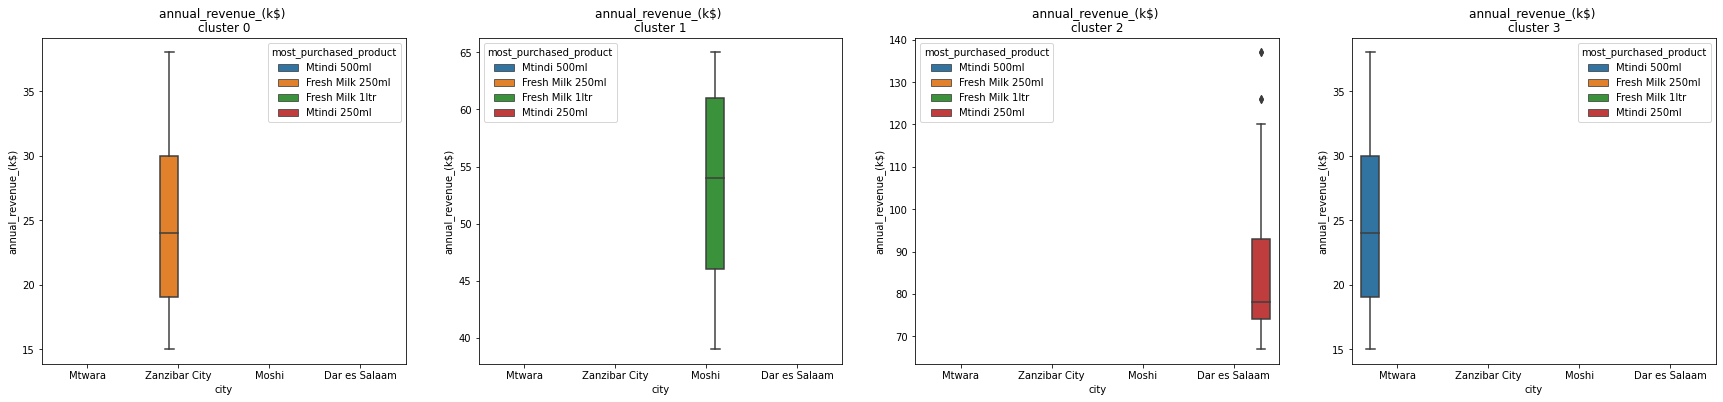

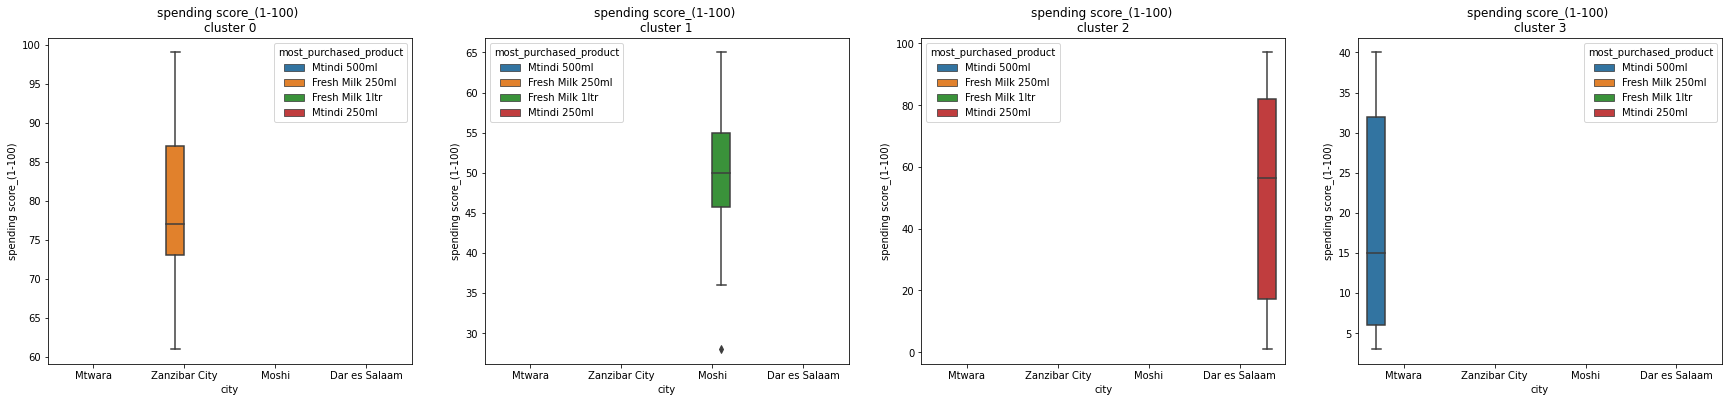

In [26]:
# plot boxplot for each feature based on cluster 
for i in df.columns[:2]:
    plt.figure(figsize=(30,6))
    for j in range(4):
        plt.subplot(1,4,j+1)
        cluster = df_cluster[df_cluster['cluster']==j]
        sns.boxplot(x="city", y=cluster[i], data=df_cluster, hue='most_purchased_product')
        #cluster[i].hist()
        plt.title('{} \ncluster {}'.format(i,j))
plt.show()

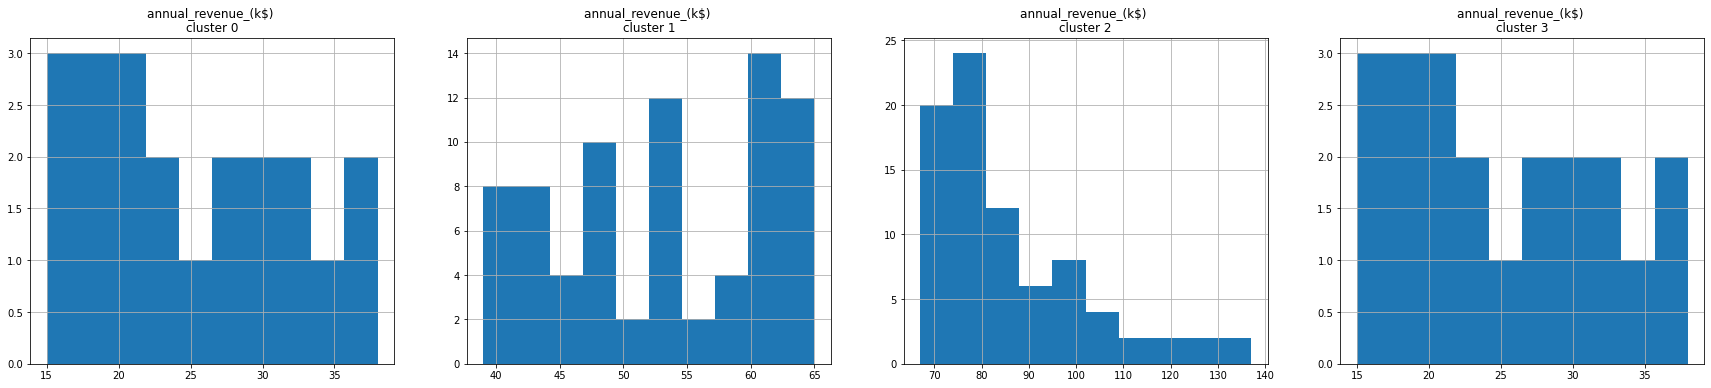

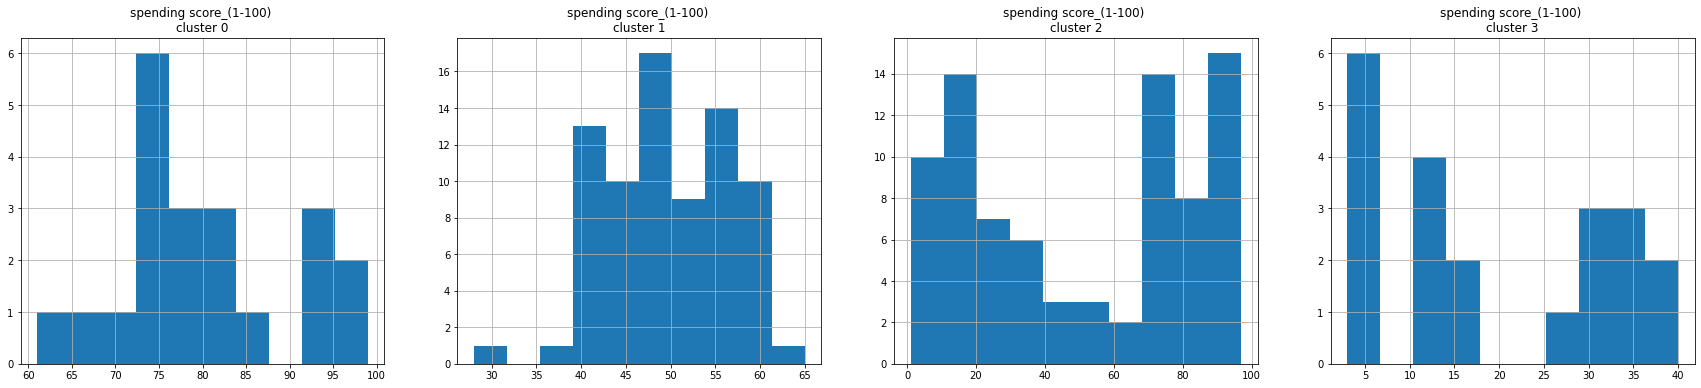

In [27]:
# plot histogram for each numerical feature based on cluster 
for i in df.columns[:2]:
    plt.figure(figsize=(30,6))
    for j in range(4):
        plt.subplot(1,4,j+1)
        cluster = df_cluster[df_cluster['cluster']==j]
        cluster[i].hist()
        plt.title('{} \ncluster {}'.format(i,j))
plt.show()

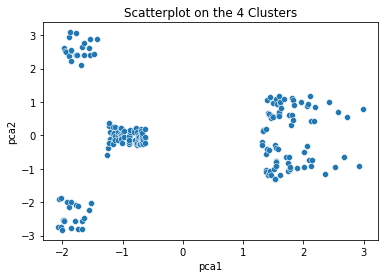

In [28]:
#Dimensionality reduction to view the 4 Clusters
pca = PCA(n_components=2)
principal_comp = pca.fit_transform(df_scaled)
pca_df = pd.DataFrame(data=principal_comp, columns=['pca1', 'pca2'])
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis=1)

# Scatter plot on the clusters
sns.scatterplot(x = "pca1", y="pca2", data = pca_df)
plt.title("Scatterplot on the 4 Clusters")
plt.show()

### Discoveries

1. There are 4 optimal clusters.
2. Each cluster represents each city.
3. Zanzibar's annual revenue averages at 25 (k\$) with spending score averaging at 80.
4. Moshi's annual revenue averages at 53 (k\$) with spending score averaging at 50.
5. Dar es Salaam's annual revenue averages at 85 (k\$) with spending score averaging at 51.
6. Mtwara's annual revenue averages at 25 (k\$) with spending score averaging at 20.


## Dimensionality Reduction With Autoencoders and Apply KMeans on Results from Encoders

In [29]:
#Using Autoencoders for dimensionality reduction and using this data in KMeans Clustering
input_df = Input(shape = (6,))
x = Dense(50, activation = 'relu')(input_df)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
encoded = Dense(8, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
x = Dense(2000, activation = 'relu', kernel_initializer = 'glorot_uniform')(encoded)
x = Dense(500, activation = 'relu', kernel_initializer = 'glorot_uniform')(x)
decoded = Dense(6, kernel_initializer = 'glorot_uniform')(x)

# autoencoder
autoencoder = Model(input_df, decoded)

# encoder - used for dimensionality reduction
encoder = Model(input_df, encoded)

autoencoder.compile(optimizer = 'adam', loss='mean_squared_error')

In [30]:
autoencoder.fit(df_scaled, df_scaled, batch_size=128, epochs=500, verbose=3)

Epoch 1/500
Epoch 2/500
Epoch 3/500
Epoch 4/500
Epoch 5/500
Epoch 6/500
Epoch 7/500
Epoch 8/500
Epoch 9/500
Epoch 10/500
Epoch 11/500
Epoch 12/500
Epoch 13/500
Epoch 14/500
Epoch 15/500
Epoch 16/500
Epoch 17/500
Epoch 18/500
Epoch 19/500
Epoch 20/500
Epoch 21/500
Epoch 22/500
Epoch 23/500
Epoch 24/500
Epoch 25/500
Epoch 26/500
Epoch 27/500
Epoch 28/500
Epoch 29/500
Epoch 30/500
Epoch 31/500
Epoch 32/500
Epoch 33/500
Epoch 34/500
Epoch 35/500
Epoch 36/500
Epoch 37/500
Epoch 38/500
Epoch 39/500
Epoch 40/500
Epoch 41/500
Epoch 42/500
Epoch 43/500
Epoch 44/500
Epoch 45/500
Epoch 46/500
Epoch 47/500
Epoch 48/500
Epoch 49/500
Epoch 50/500
Epoch 51/500
Epoch 52/500
Epoch 53/500
Epoch 54/500
Epoch 55/500
Epoch 56/500
Epoch 57/500
Epoch 58/500
Epoch 59/500
Epoch 60/500
Epoch 61/500
Epoch 62/500
Epoch 63/500
Epoch 64/500
Epoch 65/500
Epoch 66/500
Epoch 67/500
Epoch 68/500
Epoch 69/500
Epoch 70/500
Epoch 71/500
Epoch 72/500
Epoch 73/500
Epoch 74/500
Epoch 75/500
Epoch 76/500
Epoch 77/500
Epoch 78

In [31]:
encoded_df = autoencoder.predict(df_scaled)

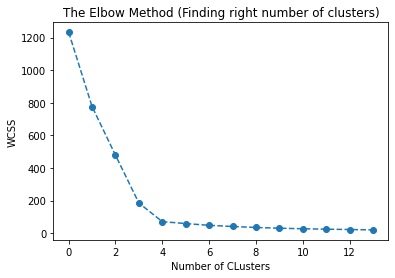

In [32]:
wcss = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i)
    kmeans.fit(encoded_df)
    wcss.append(kmeans.inertia_) # intertia is the Sum of squared distances of samples to their closest cluster center (WCSS)

plt.plot(wcss, marker='o', linestyle='--')
plt.title('The Elbow Method (Finding right number of clusters)')
plt.xlabel('Number of CLusters')
plt.ylabel('WCSS')
plt.show()

In [33]:
encoded_df.shape

(200, 6)

In [34]:
# from the above layer 4 clusters seems best choice
kmeans = KMeans(4)
kmeans.fit(encoded_df)
labels = kmeans.labels_
y = kmeans.fit_predict(df_scaled)

In [35]:
df_cluster_aen = pd.concat([df, pd.DataFrame({'cluster':labels})], axis = 1)
df_cluster_aen.head()

,annual_revenue_(k$),spending score_(1-100),city,most_purchased_product,cluster
0,15,39,Mtwara,Mtindi 500ml,2
1,15,81,Zanzibar City,Fresh Milk 250ml,3
2,16,6,Mtwara,Mtindi 500ml,2
3,16,77,Zanzibar City,Fresh Milk 250ml,3
4,17,40,Mtwara,Mtindi 500ml,2


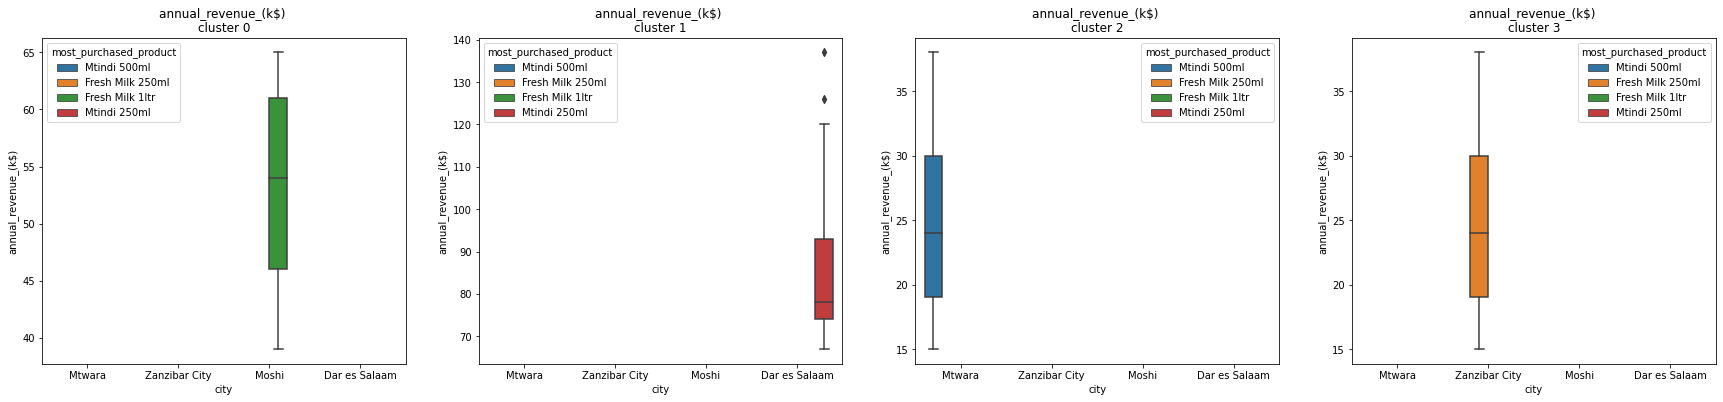

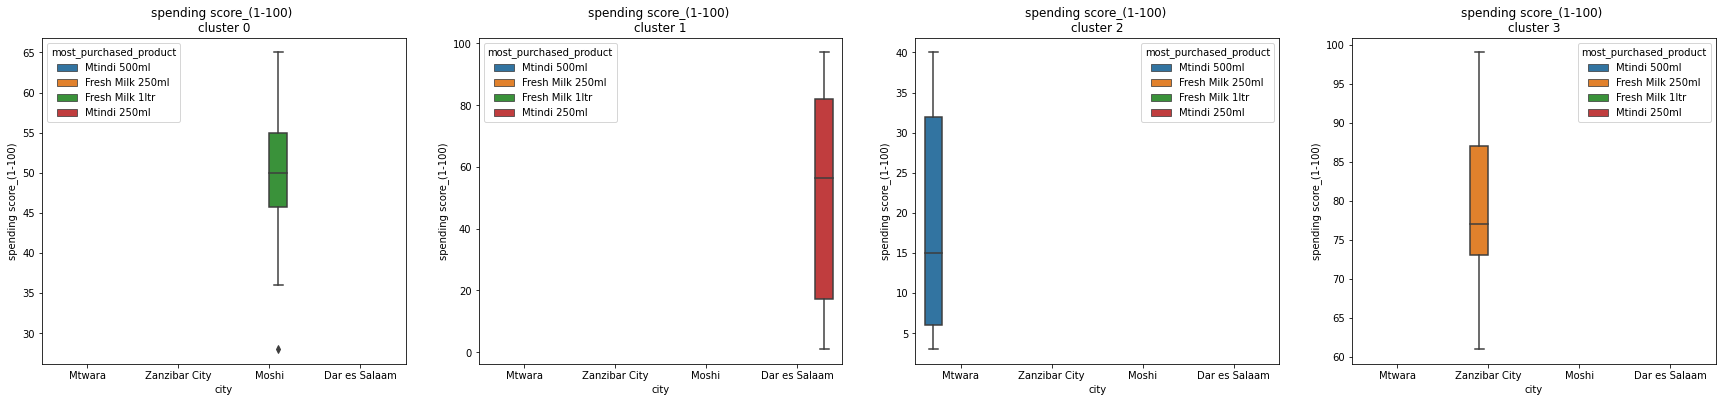

In [36]:
# plot boxplot for each feature based on cluster 
for i in df.columns[:2]:
    plt.figure(figsize=(30,6))
    for j in range(4):
        plt.subplot(1,4,j+1)
        cluster = df_cluster_aen[df_cluster_aen['cluster']==j]
        sns.boxplot(x="city", y=cluster[i], data=df_cluster_aen, hue='most_purchased_product')
        #cluster[i].hist()
        plt.title('{} \ncluster {}'.format(i,j))
plt.show()

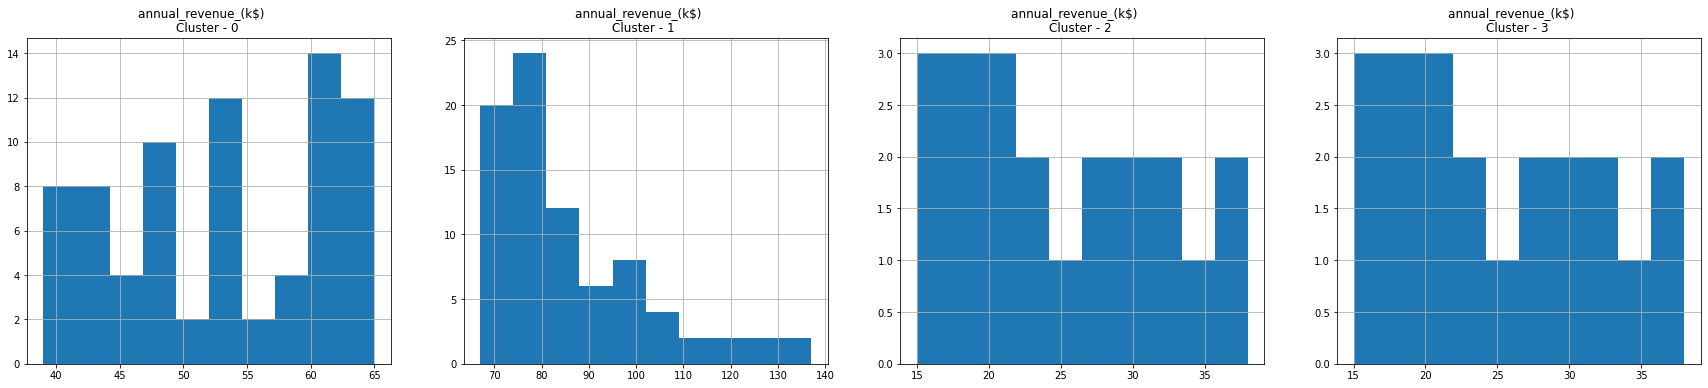

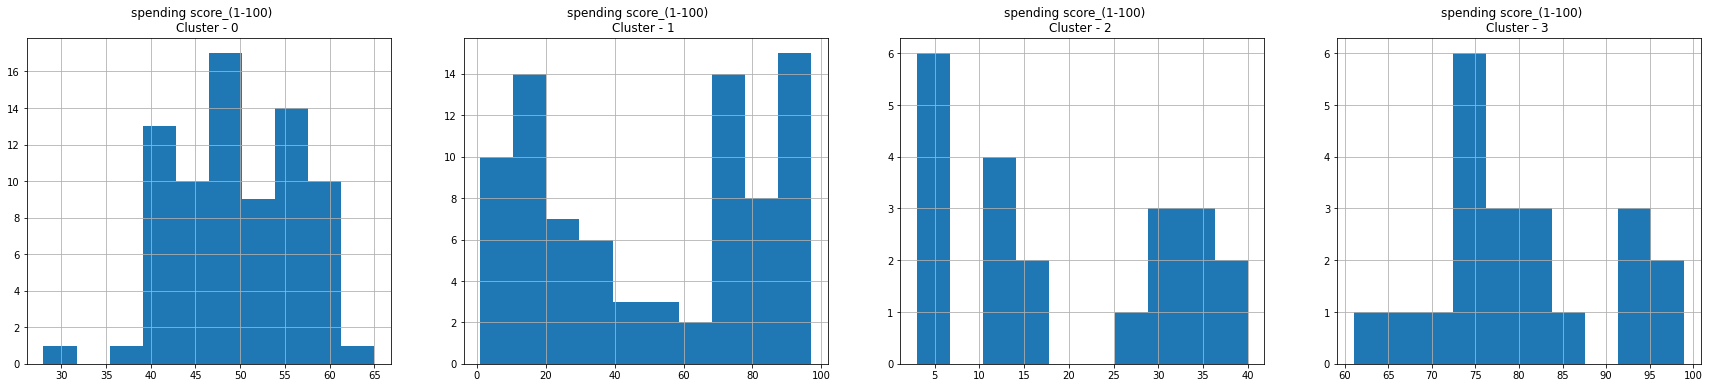

In [37]:
 #plot histogram for each feature based on cluster 
for i in df.columns[:2]:
  plt.figure(figsize = (30, 6))
  for j in range(4):
    plt.subplot(1, 4, j+1)
    cluster = df_cluster_aen[df_cluster_aen['cluster'] == j]
    cluster[i].hist()
    plt.title('{}    \nCluster - {} '.format(i,j))
  
  plt.show()

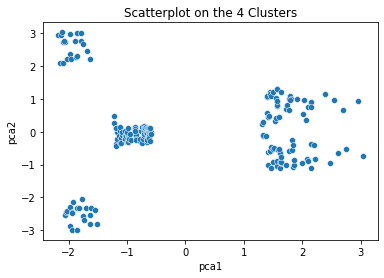

In [38]:
#View the 4 Clusters on autoencoded data
pca = PCA(n_components = 2)
prin_comp = pca.fit_transform(encoded_df)
pca_df = pd.DataFrame(data = prin_comp, columns = ['pca1', 'pca2'])
pca_df = pd.concat([pca_df, pd.DataFrame({'cluster':labels})], axis = 1)

# Scatter plot on the clusters
sns.scatterplot(x = "pca1", y="pca2", data = pca_df)
plt.title("Scatterplot on the 4 Clusters")
plt.show()

### Discoveries

The results here are same as what we had before. That is;
1. There are 4 optimal clusters.
2. Each cluster represents each city.
3. Zanzibar's annual revenue averages at 25 (k\$) with spending score averaging at 80.
4. Moshi's annual revenue averages at 53 (k\$) with spending score averaging at 50.
5. Dar es Salaam's annual revenue averages at 85 (k\$) with spending score averaging at 51.
6. Mtwara's annual revenue averages at 25 (k\$) with spending score averaging at 20.

# Conclusion & Recommendations

**From the discoveries on clustering;**
1. The merchants can be grouped by city.
2. Each city has a unique most purchased product, that is, Mtindi 500ml for Mtwara, Fresh Milk 250ml for Zanzibar, Fresh Milk 1 ltr for Moshi and Mtindi 250ml for Dar es Salaam.

**To increase sales and retain merchants, Dodoma Fresh Milk should:**
1. Spend more resources advertising to Mtwara since it has the least average spending score out of the 4 cities, yet it's annual revenue is similar to Zanzibar whose average spending score is highest.
2. Spend moderate resources advertising to Dar es Salaam and Moshi since the average spending score is 51 and 50 respectvely which is second and third in average spending scores for the 4 cities.
3. Spend less resources advertising to Zanzibar merchants since they already have a high average spending score of 80.